# Réduction d'une forêt aléatoire avec une régression Lasso

Le modèle Lasso permet de sélectionner des variables, une forêt aléatoire produit une prédiction comme étant la moyenne d'arbres de régression. Et si on mélangeait les deux ?

## Librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Données

On va partir sur ce jeu de données [Boston](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html). Le but est de prédire le prix des appartements (variable *MEDV* pour Median Value). Importer les données puis afficher l'objet dataset importé, notamment l'attribut `DESCR`.

In [2]:
from sklearn.datasets import load_boston
data = load_boston()
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Analyse exploratoire et visualisation

Créer un dataframe à partir des données du jeu Boston puis procéder à l'étape de visualisation et d'analyse exploratoire. Regarder notamment les corrélations et afficher des graphiques des variables indépendantes fortement corrélées avec la variable dépendante.

In [3]:
#df = pd.DataFrame(np.hstack((data.data, data.target.reshape(-1,1))), columns = list(data.feature_names) + ["MEDV"])
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


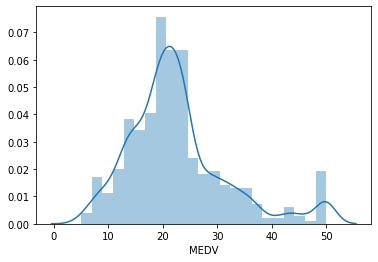

In [5]:
sns.distplot(df.MEDV);

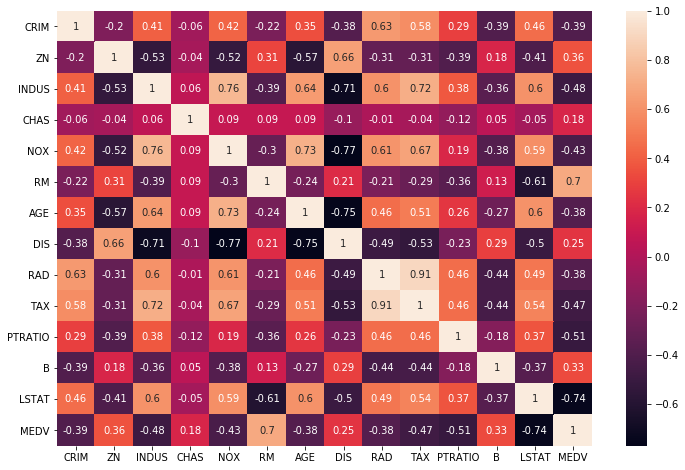

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr().round(2), annot=True);

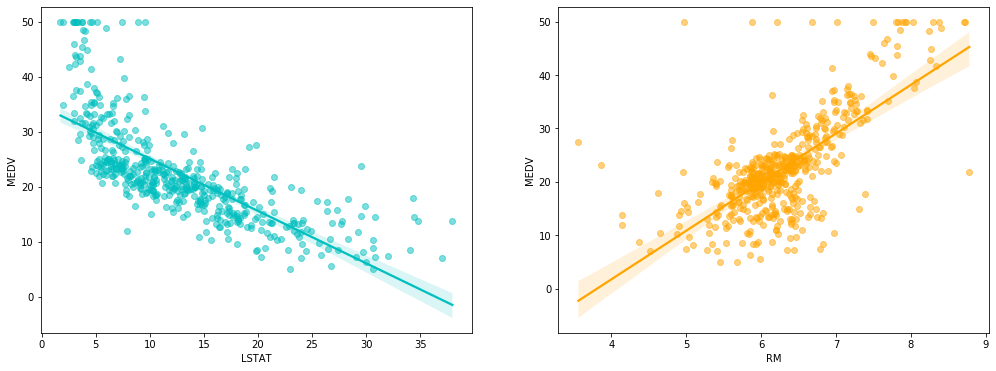

In [7]:
fig, ax = plt.subplots(1,2,figsize=(17, 6))
sns.regplot("LSTAT", "MEDV", df, ax=ax[0], color='c', scatter_kws = {'alpha':0.5})
sns.regplot("RM", "MEDV", df, ax=ax[1], color='orange', scatter_kws={'alpha':0.5});

## Préparation des différents datasets

Créer les différents jeux de données pour la modélisation : X, y puis X_train, X_test, y_train, y_test 

In [8]:
from sklearn.model_selection import train_test_split
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Une forêt aléatoire

Caler une forêt aléatoire sur l'échantillon d'entraînement.

In [9]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Comment récupérer le nombre d'arbres ? Comment récupérer les arbres eux-mêmes ?

In [10]:
# rf.estimators_
len(rf.estimators_)

100

Calculer le score du modèle. Choisir bien sûr une mesure adaptée à notre problème.

In [11]:
rf.score(X_test, y_test)

0.8809384729297904

## Moyenne des prédictions des arbres

Vérifier que la forêt retourne bien la moyenne des prédictions des différents arbres en calculant cette moyenne "à la main". On pourra vérifier que le score du modèle est le même pour s'assurer qu'on obtient bien les mêmes prédictions.

In [12]:
all_est = []
for i, est in enumerate(rf.estimators_):
    all_est.append(est.predict(X_test))

average = np.mean(all_est, axis=0)

from sklearn.metrics import r2_score
r2_score(y_test, average)

0.8809384729297904

## Pondération des arbres à l'aide d'une régression linéaire

La forêt aléatoire est une façon de créer de nouvelles variables, autant de variables que d'arbres dans la forêt. On peut donc utiliser ces nouveaux features pour caler une régression linéaire. À vous de jouer !

In [13]:
from sklearn.linear_model import LinearRegression

def new_features(forest, X):
    all_est = []
    for i, est in enumerate(forest.estimators_):
        all_est.append(est.predict(X))
    return np.array(all_est).T


X_train_2 = new_features(rf, X_train)
lr = LinearRegression()
lr.fit(X_train_2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Calculer le score de ce nouveau modèle.

In [14]:
X_test_2 = new_features(rf, X_test)
r2_score(y_test, lr.predict(X_test_2))
#lr.score(X_test_2, y_test)

0.8962843180286669

Répeter plusieurs fois les opérations précédentes afin de voir l'effet de l'aléatoire (notamment présent dans le découpage `train_test_split` et dans le `RandomForestRegressor`). Idéalement vous pouvez définir une fonction qui refait tout et l'exécuter directement.  
Qu'en conclure sur ce nouveau modèle ? Que dire du risque d'*overfitting* ?

In [15]:
def compare_rf_lm(random_state=0):
    rf = RandomForestRegressor(random_state=random_state)
    rf.fit(X_train, y_train)
    rf_score = rf.score(X_test, y_test)
    
    X_train_2 = new_features(rf, X_train)
    lr = LinearRegression()
    lr.fit(X_train_2, y_train)

    X_test_2 = new_features(rf, X_test)
    lr_score = lr.score(X_test_2, y_test)
    
    return rf_score, lr_score

In [16]:
for i in np.random.randint(0,10*6,20):
    print(i, compare_rf_lm(i))

46 (0.8735524042101679, 0.8798953047281205)
9 (0.8805952119135477, 0.8878078768792355)
44 (0.8761300452093487, 0.8762103338212236)
57 (0.8752543869854905, 0.8783501042000051)
29 (0.8742357551445716, 0.8991828758571505)
33 (0.8775956126165741, 0.8843486191264844)
38 (0.8687983639474657, 0.8934902729187144)
50 (0.8779154366525357, 0.8942630316892102)
57 (0.8752543869854905, 0.8783501042000051)
57 (0.8752543869854905, 0.8783501042000051)
47 (0.8745341234261818, 0.8907082360347364)
32 (0.873538067087958, 0.891715105103351)
30 (0.8700394432244541, 0.8967169202946611)
55 (0.8759653144374854, 0.8869995271393578)
19 (0.8758785296786393, 0.8975591375923042)
49 (0.8727781291825717, 0.8913737998101054)
36 (0.8638309828045526, 0.8924833275751725)
56 (0.8736160806877432, 0.8989935736193475)
28 (0.8733806527359393, 0.873583665143253)
25 (0.8788374709680626, 0.8726584531087572)


Effectuer un diagrammes en barres des valeurs des coefficients de la régresion linéaire.

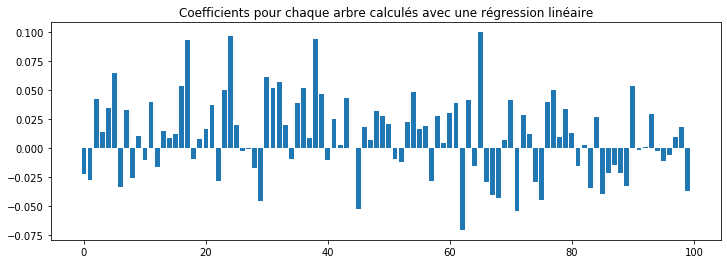

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(np.arange(0, len(lr.coef_)), lr.coef_)
ax.set_title("Coefficients pour chaque arbre calculés avec une régression linéaire");

Caler une régression linéaire sur les variables initiales et mesurer son score pour comparer avec celui obtenu sur les features issus de la forêt aléatoire.

In [18]:
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
r2_score(y_test, lr_raw.predict(X_test))

0.6733790554795117

## Pour aller plus loin : sélection de variables

Une idée pour sélectionner les variables est d'utiliser la régularisation. On a vu que la régularisation $l_1$ ou encore [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) permet de sélectionner des variables en fixant certains coefficients à 0. On peut donc tenter d'améliorer la régression précédente en utilisant une régression Lasso pour réduire la forêt aléatoire sans perdre en performance. C'est quasiment le même code. À vous !

In [19]:
from sklearn.linear_model import Lasso

lr_lasso = Lasso(max_iter=10000)
lr_lasso.fit(X_train_2, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Regarder les coefficients pour savoir quels arbres ont finalement été conservés ou non (ou plutôt combien d'arbres ont été conservés).

In [20]:
lr_lasso.coef_

array([0.        , 0.        , 0.01600195, 0.        , 0.        ,
       0.05106847, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04940647,
       0.02918843, 0.06547524, 0.07196046, 0.        , 0.        ,
       0.02898867, 0.0168009 , 0.        , 0.06900045, 0.0582061 ,
       0.00064439, 0.        , 0.        , 0.        , 0.        ,
       0.01481942, 0.        , 0.00537776, 0.00454931, 0.        ,
       0.02873549, 0.        , 0.        , 0.08941475, 0.        ,
       0.        , 0.03446642, 0.        , 0.04675889, 0.        ,
       0.        , 0.0175687 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03092548, 0.04039557,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01429188, 0.        , 0.        , 0.03384231, 0.        ,
       0.02317578, 0.        , 0.        , 0.        , 0.        ,
       0.0348489 , 0.        , 0.        , 0.01195412, 0.     

In [21]:
r2_score(y_test, lr_lasso.predict(X_test_2))

0.9039220217951105

Faire varier le paramètre `alpha` de la régression Lasso :
- avec un pas de 0.01 entre 0 et 1
- avec un pas de 0.1 entre 1 et 10

Puis tracer l'évolution de la performance et du nombre d'arbres conservés en fonction de alpha. 

In [22]:
alphas = [0.01 * i for i in range(100)] + [1 + 0.1 * i for i in range(100)]
obs = []
for i in range(len(alphas)):
    alpha = alphas[i]
    lr_lasso = Lasso(max_iter=20000, alpha=alpha)
    lr_lasso.fit(X_train_2, y_train)
    obs.append(dict(
        alpha=alpha,
        not_null=len(lr_lasso.coef_[lr_lasso.coef_!=0]),
        r2=r2_score(y_test, lr_lasso.predict(X_test_2))
    ))

/home/elka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/elka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/elka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.9746710417028, tolerance: 3.2861946015831136
  positive)
/home/elka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.980029997383241, tolerance: 3.2861946015831136
  positive)


In [23]:
df = pd.DataFrame(obs)
df.tail()

,alpha,not_null,r2
195,10.5,23,0.889763
196,10.6,23,0.889440
197,10.7,23,0.889114
198,10.8,23,0.888788
199,10.9,23,0.888446


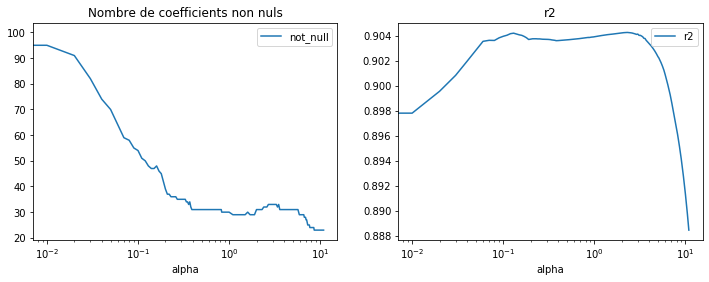

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df.plot("alpha", "not_null", ax=ax[0], logx=True)
ax[0].set_title("Nombre de coefficients non nuls")
df.plot("alpha", "r2", ax=ax[1], logx=True)
ax[1].set_title("r2");

Avec une 30aine d'arbres seulement, on obtient un prédicteur un peu plus performant (au sens du R2).